### `pysgrid` only works with raw netCDF4 (for now!)

In [1]:
from netCDF4 import Dataset

url = ('http://geoport.whoi.edu/thredds/dodsC/clay/usgs/users/'
               'jcwarner/Projects/Sandy/triple_nest/00_dir_NYB05.ncml')

nc = Dataset(url)

### The sgrid object

In [2]:
import pysgrid

sgrid = pysgrid.from_nc_dataset(nc)
sgrid  # We need a better __repr__ and __str__ !!!

### The object knows about sgrid conventions

In [3]:
sgrid.edge1_coordinates, sgrid.edge1_dimensions, sgrid.edge1_padding

((u'lon_u', u'lat_u'),
 u'xi_u: xi_psi eta_u: eta_psi (padding: both)',
 [GridPadding(mesh_topology_var=u'grid', face_dim=u'eta_u', node_dim=u'eta_psi', padding=u'both')])

In [4]:
u_var = sgrid.u
u_var.center_axis, u_var.node_axis

(1, 0)

In [5]:
v_var = sgrid.v
v_var.center_axis, v_var.node_axis

(0, 1)

### Being generic is nice!

In [6]:
u_var.center_slicing

(slice(None, None, None),
 slice(None, None, None),
 slice(1, -1, None),
 slice(None, None, None))

In [7]:
v_var.center_slicing

(slice(None, None, None),
 slice(None, None, None),
 slice(None, None, None),
 slice(1, -1, None))

(Don't be scared, you do not need the sgrid object to get the variables.  This just shows that there is a one-to-one mapping from the sgrid object to the netCDF4 object.)

In [8]:
u_velocity = nc.variables[u_var.variable]
v_velocity = nc.variables[v_var.variable]

### ... but we need a better way to deal with the slice of the slice!

In [9]:
from datetime import datetime, timedelta
from netCDF4 import date2index

t_var = nc.variables['ocean_time']
start = datetime(2012, 10, 30, 0, 0)
time_idx = date2index(start, t_var, select='nearest')

v_idx = 0

# Slice of the slice!
u_data = u_velocity[time_idx, v_idx, u_var.center_slicing[-2], u_var.center_slicing[-1]]
v_data = v_velocity[time_idx, v_idx, v_var.center_slicing[-2], v_var.center_slicing[-1]]

### Some thing for the angle information

In [10]:
angle = sgrid.angle

angles = nc.variables[angle.variable][angle.center_slicing]

### Average velocity vectors to cell centers

In [11]:
from pysgrid.processing_2d import avg_to_cell_center

u_avg = avg_to_cell_center(u_data, u_var.center_axis)
v_avg = avg_to_cell_center(v_data, v_var.center_axis)

### Rotate vectors by angles

In [12]:
from pysgrid.processing_2d import rotate_vectors

u_rot, v_rot = rotate_vectors(u_avg, v_avg, angles)

### Speed

In [13]:
from pysgrid.processing_2d import vector_sum

uv_vector_sum = vector_sum(u_rot, v_rot)

d:\virtualenv\ipynb_env\src\pysgrid\pysgrid\processing_2d.py:22: RuntimeWarning: invalid value encountered in sqrt
  vector_sum = np.sqrt(x_arr**2 + y_arr**2)


### Lon, lat of the center grid
### We'd  like to streamline this in the future.

In [14]:
grid_cell_centers = sgrid.centers  # Array of lon, lat pairs.

lon_var_name, lat_var_name = sgrid.face_coordinates

# use the longitude and latitude variable names to get their respective sgrid variables
sg_lon = getattr(sgrid, lon_var_name)
sg_lat = getattr(sgrid, lat_var_name)

lon_data = grid_cell_centers[..., 0][sg_lon.center_slicing]
lat_data = grid_cell_centers[..., 1][sg_lat.center_slicing]

### Plotting

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(figsize=figsize,
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

D:\virtualenv\ipynb_env\lib\site-packages\cartopy\io\__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


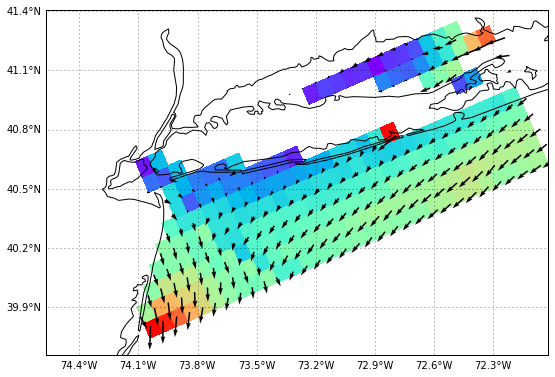

In [16]:
sub = 10
scale = 0.06

fig, ax = make_map()

kw = dict(scale=1.0/scale, pivot='middle', width=0.003, color='black')
q = plt.quiver(lon_data[::sub, ::sub], lat_data[::sub, ::sub],
               u_rot[::sub, ::sub], v_rot[::sub, ::sub], zorder=2, **kw)

cs = plt.pcolormesh(lon_data[::sub, ::sub],
                    lat_data[::sub, ::sub],
                    uv_vector_sum[::sub, ::sub], zorder=1, cmap=plt.cm.rainbow)

_ = ax.coastlines('10m')